# MOOC 학습자 이탈 예측 모델 개발

In [46]:
import kagglehub
import os
import pandas as pd

# 1. 데이터셋 다운로드
dataset_path = kagglehub.dataset_download("rocki37/open-university-learning-analytics-dataset")
print("Dataset downloaded to:", dataset_path)

# 2. 데이터 저장할 'data' 폴더 생성
data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

# 3. CSV 파일 찾기
files = os.listdir(dataset_path)
csv_files = [f for f in files if f.endswith('.csv')]
print("Found CSV files:", csv_files)

# 4. CSV 파일을 'data' 폴더에 저장
saved_files = []
for csv_file in csv_files:
    src_path = os.path.join(dataset_path, csv_file) 
    dest_path = os.path.join(data_folder, csv_file) 
    df = pd.read_csv(src_path) 
    df.to_csv(dest_path, index=False)
    saved_files.append(dest_path)
    print(f"Saved {csv_file} to {dest_path}")

# 5. 저장한 파일을 다시 읽어 DataFrame으로 정리
dataframes = {}
for saved_file in saved_files:
    df = pd.read_csv(saved_file)
    file_name = os.path.basename(saved_file)
    dataframes[file_name] = df
    print(f"Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset downloaded to: /Users/sky/.cache/kagglehub/datasets/rocki37/open-university-learning-analytics-dataset/versions/1
Found CSV files: ['studentAssessment.csv', 'studentInfo.csv', 'studentVle.csv', 'courses.csv', 'vle.csv', 'studentRegistration.csv', 'assessments.csv']
Saved studentAssessment.csv to data/studentAssessment.csv
Saved studentInfo.csv to data/studentInfo.csv
Saved studentVle.csv to data/studentVle.csv
Saved courses.csv to data/courses.csv
Saved vle.csv to data/vle.csv
Saved studentRegistration.csv to data/studentRegistration.csv
Saved assessments.csv to data/assessments.csv
Loaded studentAssessment.csv: 173912 rows, 5 columns
Loaded studentInfo.csv: 32593 rows, 12 columns
Loaded studentVle.csv: 10655280 rows, 6 columns
Loaded courses.csv: 22 rows, 3 columns
Loaded vle.csv: 6364 rows, 6 columns
Loaded studentRegistration.csv: 32593 rows, 5 columns
Loaded assessments.csv: 206 rows, 6 columns


In [47]:
studentAssessment_df = dataframes["studentAssessment.csv"]
studentAssessment_df

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


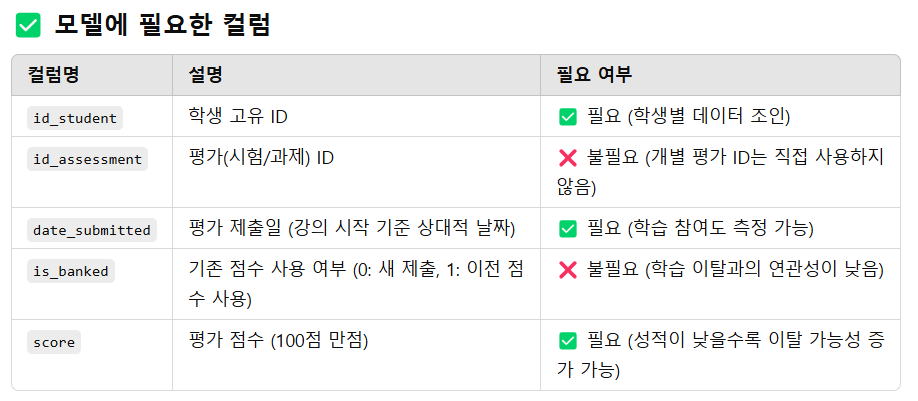

#### 모델 활용 목적
- id_student → 학생별 데이터 결합을 위해 필요 (studentInfo.csv, studentVle.csv 등과 조인)

- date_submitted → 학생이 평가를 제출한 시점을 활용하여 늦게 제출하는 경향이 이탈 가능성을 높이는지 분석 가능

- score → 낮은 점수를 받은 학생이 이후 과목에서 이탈할 가능성이 높은지 예측 가능

#### 불필요한 컬럼 제거
- id_assessment → 특정 시험이나 과제의 ID이며, 모델 학습에는 직접적인 영향을 주지 않음. 대신 평균 점수나 제출 패턴을 보는 것이 더 유용함.

- is_banked → 기존 점수를 재사용했는지 여부이므로, 학생의 학습 참여도와는 큰 상관이 없을 가능성이 높음.


In [48]:
studentAssessment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [49]:
# score null 행 제거 ()
studentAssessment_df = studentAssessment_df.dropna(subset=["score"])
studentAssessment_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 173739 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173739 non-null  int64  
 1   id_student      173739 non-null  int64  
 2   date_submitted  173739 non-null  int64  
 3   is_banked       173739 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 8.0 MB


In [50]:
studentAssessment_df.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173739.000000,1.737390e+05,173739.000000,173739.000000,173739.000000
mean,26555.615826,7.052474e+05,116.020226,0.010982,75.799573
std,8829.999907,5.524822e+05,71.479612,0.104218,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044660e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852220e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.345000e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


In [51]:
studentVle_df = dataframes["studentVle.csv"]
studentVle_df

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


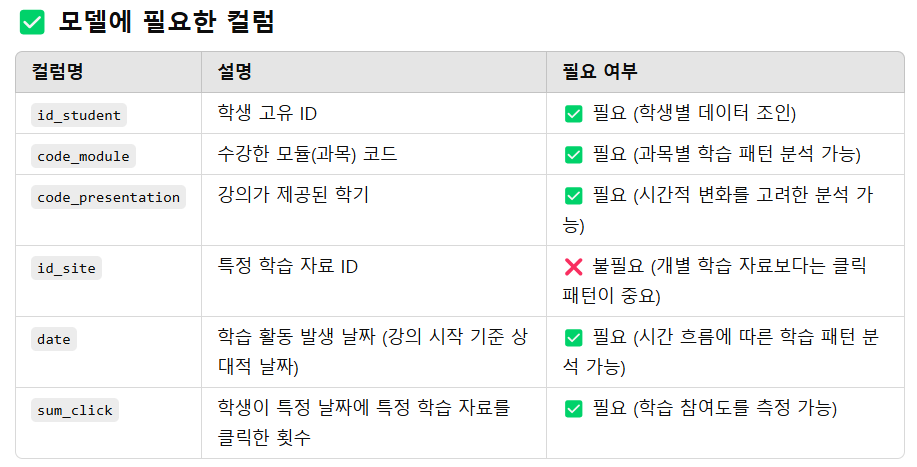

#### 모델 활용 목적
- id_student → 학생별 학습 로그를 결합하기 위해 필요 (studentInfo.csv, studentAssessment.csv 등과 조인)

- code_module, code_presentation → 과목별 학습 패턴을 분석하고, 특정 강좌에서 이탈률이 높은지 확인 가능

- date → 시간 흐름에 따른 학습 참여도 변화를 측정하여 초반 활동량이 낮거나 감소하는 패턴이 이탈과 연관되는지 분석 가능

- sum_click → 학생이 학습 자료를 얼마나 적극적으로 활용했는지를 나타내며, 클릭 수가 적을수록 이탈 가능성이 높을 수 있음

### 불필요한 컬럼 제거 이유
- id_site → 개별 학습 자료 ID이며, 학생이 특정 자료를 클릭했는지 여부보다는 **전체적인 학습 활동량(sum_click)**이 더 중요한 특징이 될 가능성이 높음.

#### 추가적으로 활용 가능한 파생 변수
- total_clicks_per_student (총 클릭 수) → 특정 학생이 전체 학습 기간 동안 수행한 클릭 수 합계로, 학습 활동량이 적을수록 이탈 가능성이 높을 수 있음

- click_trend (클릭 변화 추이) → date를 기준으로 클릭 수의 증가 또는 감소 추세 분석
초반 클릭 수가 높았지만 후반부로 갈수록 감소하는 경우 이탈 가능성이 증가할 수 있음

- avg_daily_clicks (평균 일일 클릭 수) → 학생별 하루 평균 학습 활동량
학습 패턴을 분석하여, 일일 클릭 수가 평균보다 낮은 학생이 이탈할 가능성이 있는지 확인 가능


In [52]:
studentVle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [53]:
studentVle_df.describe()

,id_student,id_site,date,sum_click
count,1.065528e+07,1.065528e+07,1.065528e+07,1.065528e+07
mean,7.333336e+05,7.383234e+05,9.517400e+01,3.716946e+00
std,5.827060e+05,1.312196e+05,7.607130e+01,8.849047e+00
min,6.516000e+03,5.267210e+05,-2.500000e+01,1.000000e+00
25%,5.077430e+05,6.735190e+05,2.500000e+01,1.000000e+00
50%,5.882360e+05,7.300690e+05,8.600000e+01,2.000000e+00
75%,6.464840e+05,8.770300e+05,1.560000e+02,3.000000e+00
max,2.698588e+06,1.049562e+06,2.690000e+02,6.977000e+03


In [54]:
studentInfo_df = dataframes["studentInfo.csv"]
studentRegistration_df = dataframes["studentRegistration.csv"]
Assessment_df = dataframes["assessments.csv"]

In [55]:
import pandas as pd

# 필요한 데이터 로드
studentInfo_df = pd.read_csv('./data/studentInfo.csv')[["id_student", "code_module", "highest_education", "studied_credits", "imd_band", "final_result"]]
# studentRegistration_df = pd.read_csv('./data/studentRegistration.csv')[["id_student"]]
studentVle_df = pd.read_csv('./data/studentVle.csv')[["id_student", "sum_click", "date"]]
studentAssessment_df = pd.read_csv('./data/studentAssessment.csv')[["id_assessment","id_student", "score"]]
# assessments_df = pd.read_csv('./data/assessments.csv')[['date','id_assessment']]

# 데이터 병합
# merged_data = pd.merge(studentInfo_df, studentRegistration_df, on='id_student', how='inner')
# ass_merged_data = pd.merge(studentAssessment_df, assessments_df, on='id_assessment', how='inner')
final_merged_data = pd.merge(studentInfo_df, studentAssessment_df, on='id_student', how='inner')

# id_student 기준으로 sum_click 합산 및 평균 계산
studentVle_agg = studentVle_df.groupby('id_student').agg(
    sum_click=('sum_click', 'sum'),  # 총 클릭 수
    mean_click=('sum_click', 'mean') # 평균 클릭 수
).reset_index()

# 기존 데이터와 병합
final_merged_data = pd.merge(final_merged_data, studentVle_agg, on='id_student', how='left')

# 결측치 처리 (학습 활동 기록이 없는 학생은 sum_click=0, mean_click=0)
final_merged_data['sum_click'] = final_merged_data['sum_click'].fillna(0)
final_merged_data['mean_click'] = final_merged_data['mean_click'].fillna(0)

# 병합된 데이터 저장
final_merged_data.to_csv('./data/merged_data.csv', index=False)

# 병합된 데이터 정보 출력
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207319 entries, 0 to 207318
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_student         207319 non-null  int64  
 1   code_module        207319 non-null  object 
 2   highest_education  207319 non-null  object 
 3   studied_credits    207319 non-null  int64  
 4   imd_band           198004 non-null  object 
 5   final_result       207319 non-null  object 
 6   id_assessment      207319 non-null  int64  
 7   score              207092 non-null  float64
 8   sum_click          207319 non-null  float64
 9   mean_click         207319 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 15.8+ MB


In [56]:
final_merged_data['imd_band'] = final_merged_data['imd_band'].fillna('20-30%')
final_merged_data['score'] = final_merged_data['score'].fillna(0)
final_merged_data['imd_band'] = final_merged_data['imd_band'].replace('10-20', '10-20%')
final_merged_data.to_csv('./data/merged_data.csv', index=False)
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207319 entries, 0 to 207318
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_student         207319 non-null  int64  
 1   code_module        207319 non-null  object 
 2   highest_education  207319 non-null  object 
 3   studied_credits    207319 non-null  int64  
 4   imd_band           207319 non-null  object 
 5   final_result       207319 non-null  object 
 6   id_assessment      207319 non-null  int64  
 7   score              207319 non-null  float64
 8   sum_click          207319 non-null  float64
 9   mean_click         207319 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 15.8+ MB


### 데이터 분석 및 시각화

In [57]:
withdrawn_rate = final_merged_data["final_result"].value_counts(normalize=True) * 100
print("📌 이탈률 분포:\n", withdrawn_rate)

📌 이탈률 분포:
 final_result
Pass           56.929177
Fail           15.905923
Distinction    14.636382
Withdrawn      12.528519
Name: proportion, dtype: float64


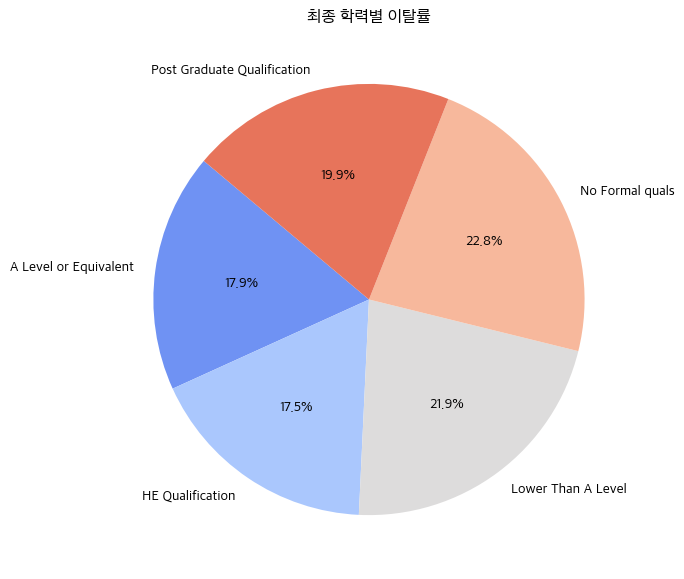

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib

# font_path = 'C:/Windows/Fonts/malgunbd.ttf'
# font = fm.FontProperties(fname=font_path).get_name()
# matplotlib.rc('font', family=font)

font_name = "Apple SD Gothic Neo"
matplotlib.rc('font', family=font_name)

# 이탈 여부 별 색상 설정
palette = {"Withdrawn": "red", "Pass": "blue", "Fail": "orange", "Distinction": "green"}

# 1️⃣ 학력별 이탈률 - 파이 차트
education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(7, 7))
plt.pie(education_withdrawn.values, labels=education_withdrawn.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(education_withdrawn)), startangle=140)
plt.title("최종 학력별 이탈률")
plt.show()

/var/folders/st/bf749bkd2lv_11d1rlyjcgz00000gn/T/ipykernel_54497/1184413172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")


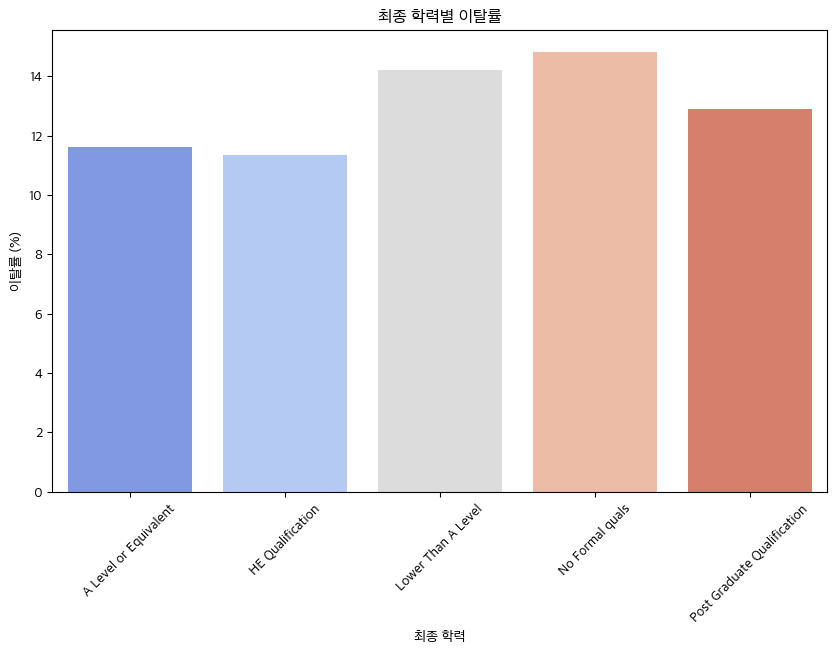

In [59]:
plt.figure(figsize=(10, 6))
education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")
plt.title("최종 학력별 이탈률")
plt.xlabel("최종 학력")
plt.ylabel("이탈률 (%)")
plt.xticks(rotation=45)
plt.show()

/var/folders/st/bf749bkd2lv_11d1rlyjcgz00000gn/T/ipykernel_54497/2933616941.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")


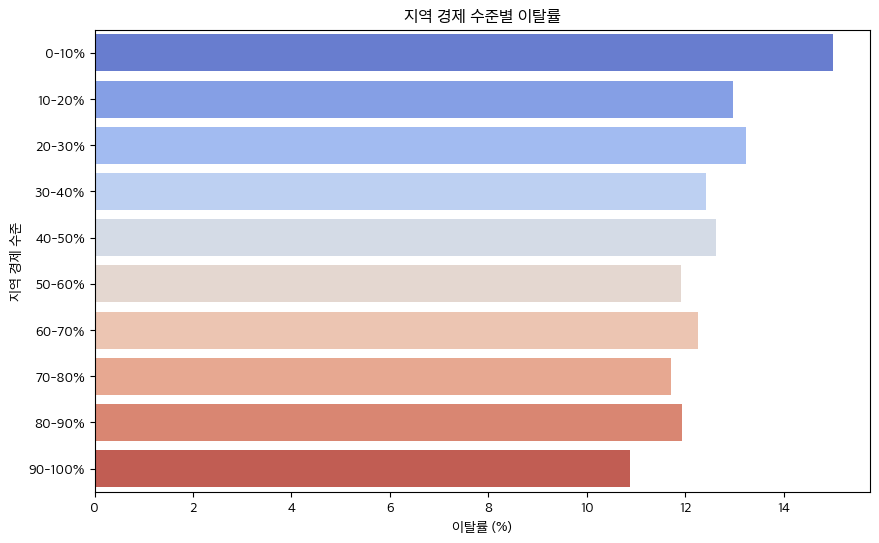

In [60]:
# 2️⃣ 경제 수준별 이탈률 - 가로 막대 그래프
imd_withdrawn = final_merged_data.groupby("imd_band")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(10, 6))
sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")
plt.title("지역 경제 수준별 이탈률")
plt.xlabel("이탈률 (%)")
plt.ylabel("지역 경제 수준")
plt.show()

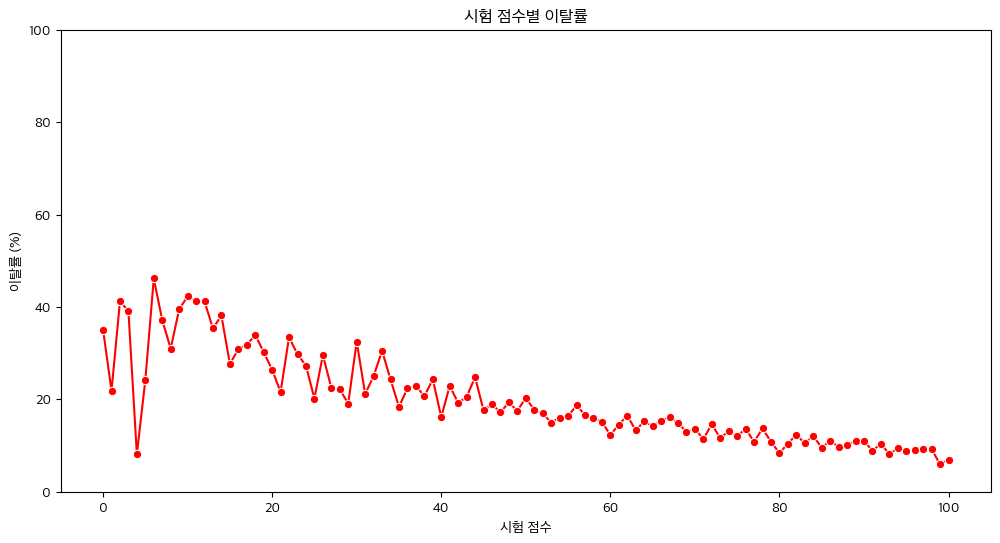

In [61]:
plt.figure(figsize=(12, 6))
score_withdrawn = final_merged_data.groupby("score")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.lineplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red", marker="o")
plt.title("시험 점수별 이탈률")
plt.xlabel("시험 점수")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100)
plt.show()

/var/folders/st/bf749bkd2lv_11d1rlyjcgz00000gn/T/ipykernel_54497/3539651876.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


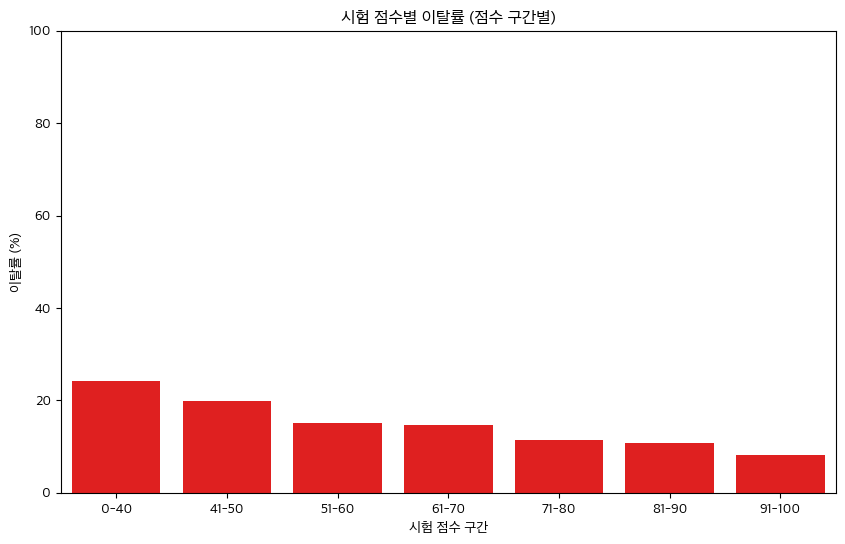

In [62]:
# 시험 점수를 구간별로 나누기
final_merged_data["score_bins"] = pd.cut(final_merged_data["score"], bins=[0, 40, 50, 60, 70, 80, 90, 100], labels=["0-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])

# 점수 구간별 이탈률 계산
score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red")
plt.title("시험 점수별 이탈률 (점수 구간별)")
plt.xlabel("시험 점수 구간")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100)  # 0~100% 범위 설정
plt.show()

/var/folders/st/bf749bkd2lv_11d1rlyjcgz00000gn/T/ipykernel_54497/2964899727.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


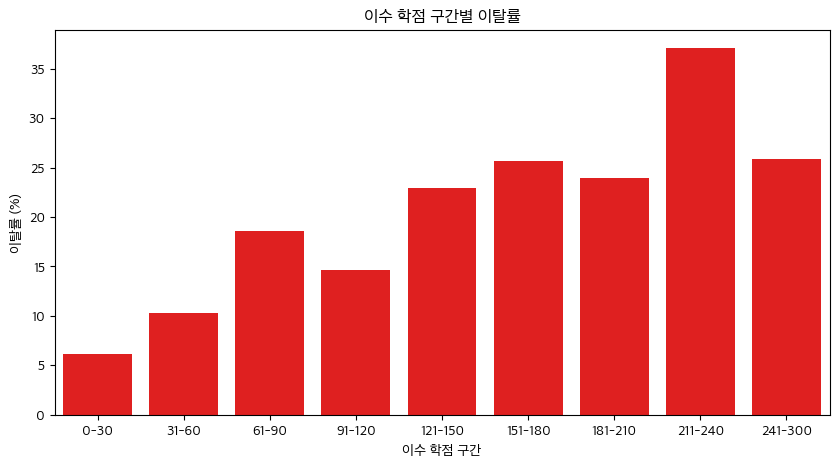

In [63]:
# 이수 학점 구간 생성
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 210, 240, 300], labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-210", "211-240", "241-300"])

# 학점 구간별 이탈률 계산
credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=credit_withdrawn.index, y=credit_withdrawn.values, color="red")
plt.title("이수 학점 구간별 이탈률")
plt.xlabel("이수 학점 구간")
plt.ylabel("이탈률 (%)")
plt.show()


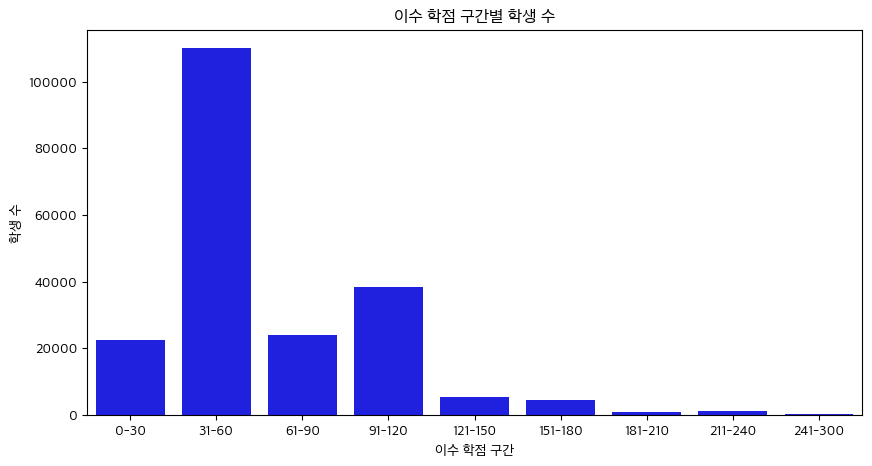

In [64]:
# 학점 구간별 학생 수 확인
credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_counts.index, y=credit_counts.values, color="blue")
plt.title("이수 학점 구간별 학생 수")
plt.xlabel("이수 학점 구간")
plt.ylabel("학생 수")
plt.show()


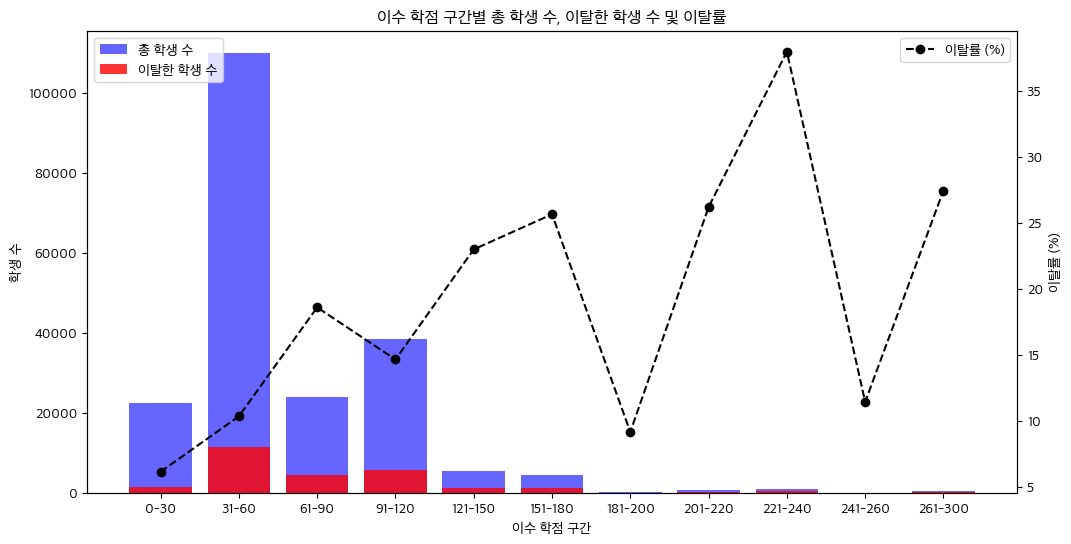

In [65]:
# 학점 구간 생성
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 200, 220, 240, 260, 300], 
                                          labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-200", "201-220", "221-240", "241-260", "261-300"])

# 학점 구간별 총 학생 수 & 이탈한 학생 수
credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()
credit_withdrawn_counts = final_merged_data[final_merged_data["final_result"] == "Withdrawn"]["credit_bins"].value_counts().sort_index()

# 데이터프레임으로 정리
credit_df = pd.DataFrame({"총 학생 수": credit_counts, "이탈한 학생 수": credit_withdrawn_counts}).fillna(0)
credit_df["이탈률 (%)"] = (credit_df["이탈한 학생 수"] / credit_df["총 학생 수"]) * 100

# 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 첫 번째 Y축 (총 학생 수, 이탈한 학생 수)
ax1.bar(credit_df.index, credit_df["총 학생 수"], color="blue", alpha=0.6, label="총 학생 수")
ax1.bar(credit_df.index, credit_df["이탈한 학생 수"], color="red", alpha=0.8, label="이탈한 학생 수")
ax1.set_ylabel("학생 수")
ax1.set_xlabel("이수 학점 구간")
ax1.legend(loc="upper left")

# 두 번째 Y축 (이탈률 %)
ax2 = ax1.twinx()
ax2.plot(credit_df.index, credit_df["이탈률 (%)"], color="black", marker="o", linestyle="dashed", label="이탈률 (%)")
ax2.set_ylabel("이탈률 (%)")
ax2.legend(loc="upper right")

plt.title("이수 학점 구간별 총 학생 수, 이탈한 학생 수 및 이탈률")
plt.show()


In [66]:
final_merged_data = final_merged_data.drop(columns=['score_bins', 'credit_bins'], axis=1)

## Data Labeling

In [67]:
# 데이터 전처리 (범주형 데이터 -> 수치형 데이터로 변환)

# highest_education 컬럼은 교육 수준을 나타내는 범주형(문자형) 데이터 -> 수치형 데이터로 변환
new_education_encodings = {
    'Post Graduate Qualification': 0,
    'HE Qualification': 1,
    'A Level or Equivalent': 2,
    'Lower Than A Level': 3,
    'No Formal quals': 4
}

final_merged_data['highest_education'] = final_merged_data['highest_education'].map(new_education_encodings)

final_merged_data.head(5)

# final_result 컬럼을 이진 분류(Binary Classification) 형태로 변환.
# Withdrawn (중도 포기) → 0, 그 외 (Distinction, Fail, Pass) → 1
 #즉, 이탈 여부를 나타내는 새로운 변수로 변환:
# 0 = 학습 포기 (Withdrawn)
# 1 = 학습 지속 (Pass, Fail, Distinction)

new_final_result_encodings = {
    'Withdrawn': 0,
    'Distinction': 1,
    'Fail': 1,
    'Pass': 1
}

final_merged_data['final_result'] = final_merged_data['final_result'].map(new_final_result_encodings)

final_merged_data.head(20)

# ode_module과 imd_band는 범주형 변수, 따라서 이를 숫자로 변환하는 과정.        ex) code_module:        imd_band (소득 수준 그룹):
# LabelEncoder()를 사용하여 각각의 고유한 문자열을 숫자로 변환.                      "AAA" → 0          "0-10%" → 0
# fit_transform()을 사용하여 문자를 고유한 정수값으로 매핑.                         "BBB" → 1           "10-20%" → 1
#                                                                                "CCC" → 2           "20-30%" → 2
from sklearn.preprocessing import LabelEncoder

# 데이터 복사
final_merged_data = final_merged_data.copy()

# LabelEncoder 초기화
label_encoder = LabelEncoder()

# 범주형 변수에 Label Encoding 적용
categorical_columns = ["code_module", "imd_band",]
for col in categorical_columns:
    final_merged_data[col] = label_encoder.fit_transform(final_merged_data[col])

In [68]:
final_merged_data

,id_student,code_module,highest_education,studied_credits,imd_band,final_result,id_assessment,score,sum_click,mean_click
0,11391,0,1,240,9,1,1752,78.0,934.0,4.765306
1,11391,0,1,240,9,1,1753,85.0,934.0,4.765306
2,11391,0,1,240,9,1,1754,80.0,934.0,4.765306
3,11391,0,1,240,9,1,1755,85.0,934.0,4.765306
4,11391,0,1,240,9,1,1756,82.0,934.0,4.765306
...,...,...,...,...,...,...,...,...,...,...
207314,2684003,6,1,30,5,1,37437,60.0,616.0,3.403315
207315,2684003,6,1,30,5,1,37438,100.0,616.0,3.403315
207316,2684003,6,1,30,5,1,37439,60.0,616.0,3.403315
207317,2684003,6,1,30,5,1,37440,100.0,616.0,3.403315


Text(0, 0.5, '빈도')

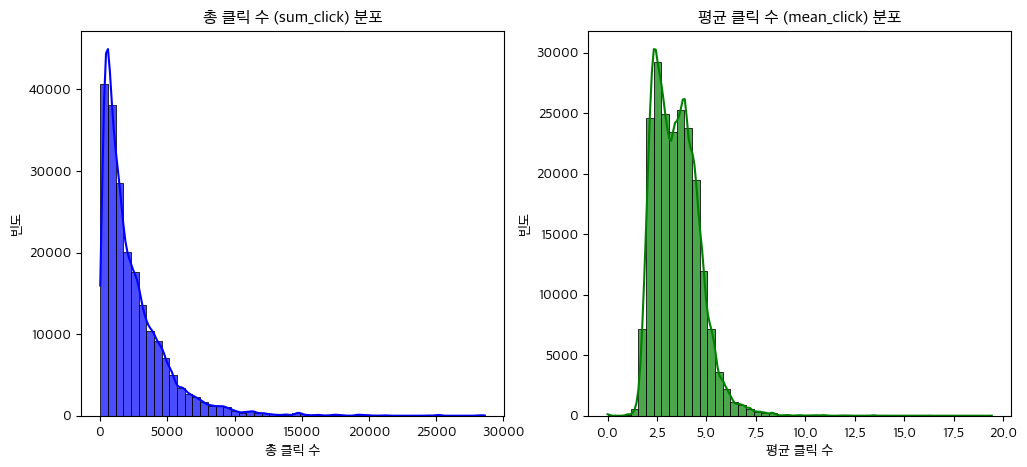

In [69]:
# 시각화 설정
plt.figure(figsize=(12, 5))

# 총 클릭 수 분포 (sum_click)
plt.subplot(1, 2, 1)
sns.histplot(final_merged_data["sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("총 클릭 수 (sum_click) 분포")
plt.xlabel("총 클릭 수")
plt.ylabel("빈도")

# 평균 클릭 수 분포 (mean_click)
plt.subplot(1, 2, 2)
sns.histplot(final_merged_data["mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("평균 클릭 수 (mean_click) 분포")
plt.xlabel("평균 클릭 수")
plt.ylabel("빈도")

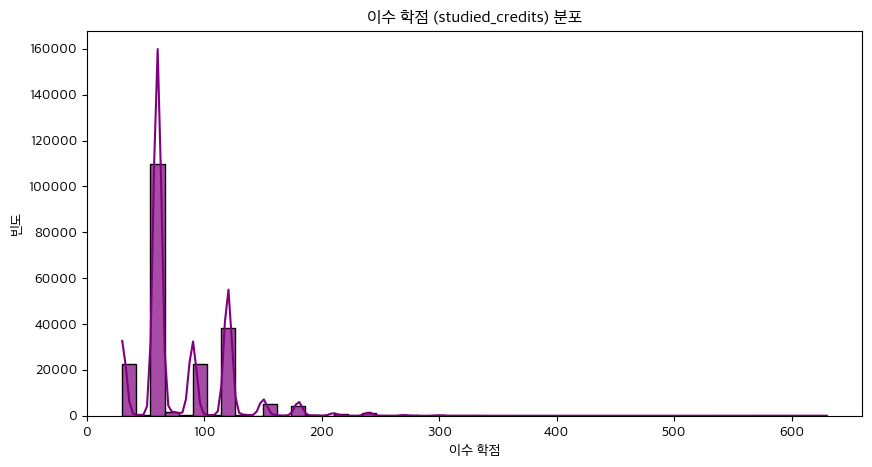

In [70]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("이수 학점 (studied_credits) 분포")
plt.xlabel("이수 학점")
plt.ylabel("빈도")
plt.show()

### Log Scaling 진행
- sum_click (총 클릭 수) → 오른쪽 꼬리가 긴 비대칭 분포 (Right-skewed)
- mean_click (평균 클릭 수) → 완만한 비대칭 분포지만, 특정 범위에 밀집

따라서, 분포를 정규 분포에 가깝게 변형하는 Log Scaling 진행


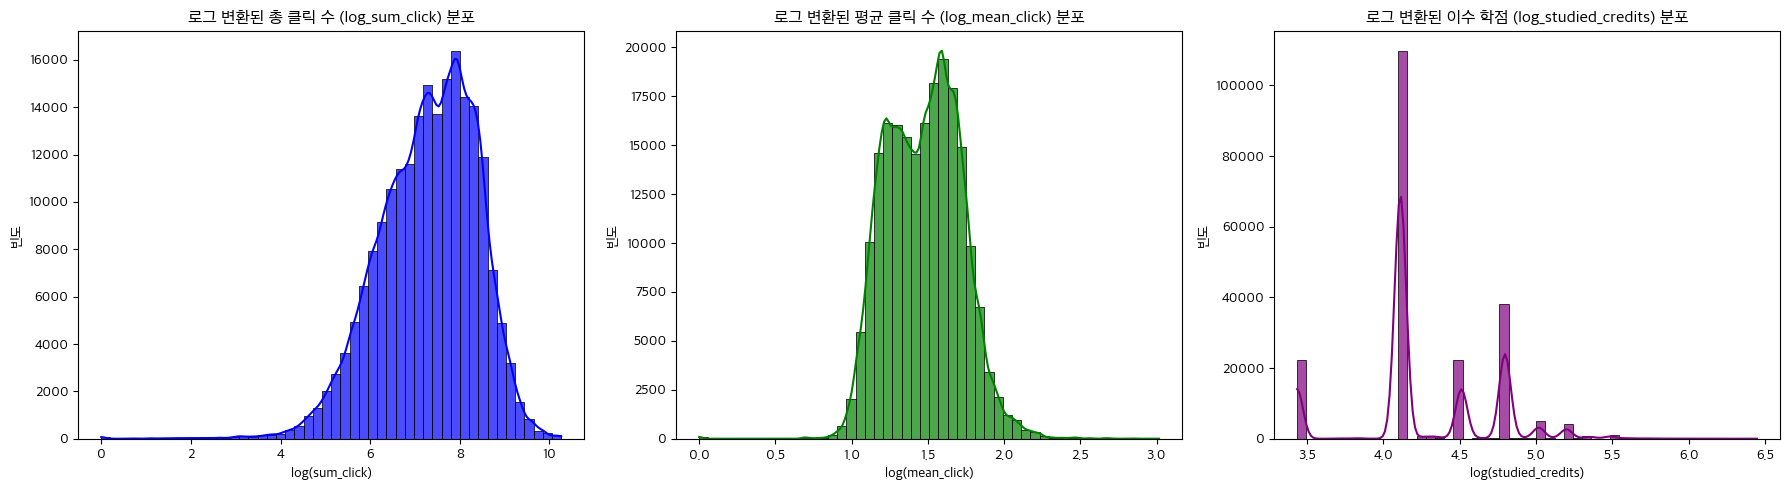

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 로그 변환
final_merged_data["log_sum_click"] = np.log1p(final_merged_data["sum_click"])
final_merged_data["log_mean_click"] = np.log1p(final_merged_data["mean_click"])
final_merged_data["log_studied_credits"] = np.log1p(final_merged_data["studied_credits"])

# 히스토그램 + KDE
plt.figure(figsize=(18, 5))

# 로그 변환된 총 클릭 수 (log_sum_click) 분포
plt.subplot(1, 3, 1)
sns.histplot(final_merged_data["log_sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("로그 변환된 총 클릭 수 (log_sum_click) 분포")
plt.xlabel("log(sum_click)")
plt.ylabel("빈도")

# 로그 변환된 평균 클릭 수 (log_mean_click) 분포
plt.subplot(1, 3, 2)
sns.histplot(final_merged_data["log_mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("로그 변환된 평균 클릭 수 (log_mean_click) 분포")
plt.xlabel("log(mean_click)")
plt.ylabel("빈도")

# 로그 변환된 이수 학점 (log_studied_credits) 분포
plt.subplot(1, 3, 3)
sns.histplot(final_merged_data["log_studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("로그 변환된 이수 학점 (log_studied_credits) 분포")
plt.xlabel("log(studied_credits)")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()


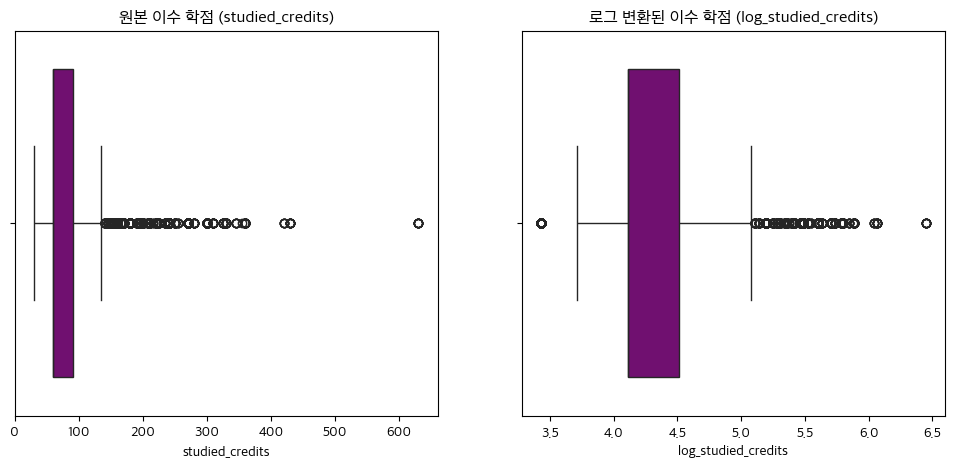

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# 원본 이수 학점 분포
plt.subplot(1, 2, 1)
sns.boxplot(x=final_merged_data["studied_credits"], color="purple")
plt.title("원본 이수 학점 (studied_credits)")

# 로그 변환된 이수 학점 분포
plt.subplot(1, 2, 2)
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

plt.show()


In [73]:
final_merged_data = final_merged_data[final_merged_data["log_studied_credits"] > 3.5]

Text(0.5, 1.0, '로그 변환된 이수 학점 (log_studied_credits)')

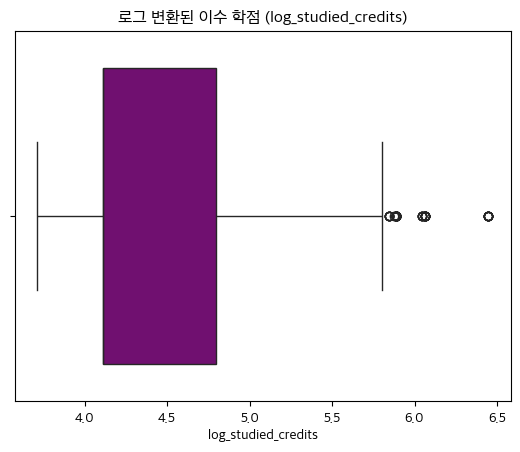

In [74]:
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

### score (시험 점수) MinMaxScaler
- 정규 분포를 따르지 않으므로 MinmaxScalar를 사용

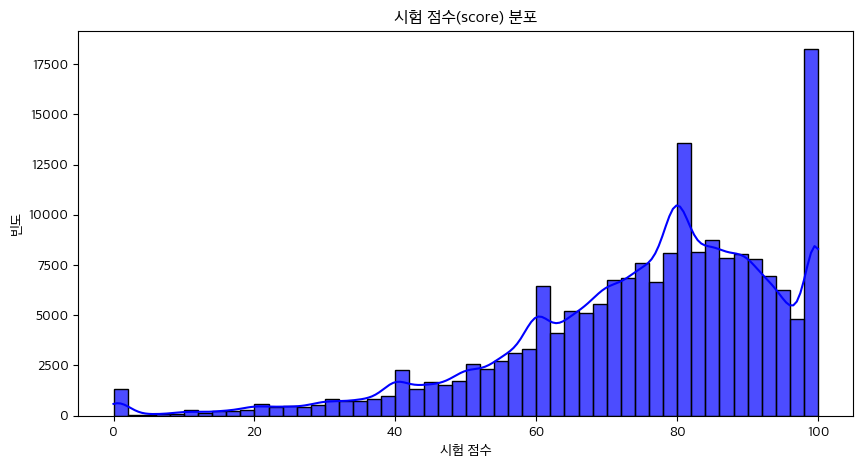

In [75]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["score"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("시험 점수(score) 분포")
plt.xlabel("시험 점수")
plt.ylabel("빈도")
plt.show()

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_merged_data["scaled_studied_credits"] = scaler.fit_transform(final_merged_data[["studied_credits"]])
final_merged_data["scaled_score"] = scaler.fit_transform(final_merged_data[["score"]])

/var/folders/st/bf749bkd2lv_11d1rlyjcgz00000gn/T/ipykernel_54497/3424977545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged_data["scaled_studied_credits"] = scaler.fit_transform(final_merged_data[["studied_credits"]])
/var/folders/st/bf749bkd2lv_11d1rlyjcgz00000gn/T/ipykernel_54497/3424977545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged_data["scaled_score"] = scaler.fit_transform(final_merged_data[["score"]])


In [77]:
final_merged_data

,id_student,code_module,highest_education,studied_credits,imd_band,final_result,id_assessment,score,sum_click,mean_click,log_sum_click,log_mean_click,log_studied_credits,scaled_studied_credits,scaled_score
0,11391,0,1,240,9,1,1752,78.0,934.0,4.765306,6.840547,1.751858,5.484797,0.338983,0.78
1,11391,0,1,240,9,1,1753,85.0,934.0,4.765306,6.840547,1.751858,5.484797,0.338983,0.85
2,11391,0,1,240,9,1,1754,80.0,934.0,4.765306,6.840547,1.751858,5.484797,0.338983,0.80
3,11391,0,1,240,9,1,1755,85.0,934.0,4.765306,6.840547,1.751858,5.484797,0.338983,0.85
4,11391,0,1,240,9,1,1756,82.0,934.0,4.765306,6.840547,1.751858,5.484797,0.338983,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206948,695951,6,3,90,4,1,37439,80.0,923.0,3.356364,6.828712,1.471638,4.510860,0.084746,0.80
206949,695951,6,3,90,4,1,37440,80.0,923.0,3.356364,6.828712,1.471638,4.510860,0.084746,0.80
206950,695951,6,3,90,4,1,37441,100.0,923.0,3.356364,6.828712,1.471638,4.510860,0.084746,1.00
206951,695951,6,3,90,4,1,37442,100.0,923.0,3.356364,6.828712,1.471638,4.510860,0.084746,1.00


In [78]:
final_merged_data.to_csv('./data/final_merge_data', index=False)

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, r2_score


selected_features = ['highest_education', 'imd_band', 'log_sum_click', 'log_studied_credits', 'scaled_score']
X = final_merged_data[selected_features]
y = final_merged_data['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, max_features='log2')

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
r2 = r2_score(y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"R² Score: {r2:.4f}")

Accuracy: 88.22%
F1 Score: 0.8615
R² Score: -0.0212


In [101]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

xgb = XGBClassifier(n_estimators=200, max_depth=10, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))


/Users/sky/Documents/skn/skn-2nd-1Team/SKN09-2nd-1Team/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:07:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8844905905256327


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
r2 = r2_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"R² Score: {r2:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 88.37%
F1 Score: 0.8594
R² Score: -0.0086


In [112]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'min_child_weight': [1, 3],
    'gamma': [0.1, 0.2]
}

# Initialize XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 128 candidates, totalling 640 fits


/Users/sky/Documents/skn/skn-2nd-1Team/SKN09-2nd-1Team/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sky/Documents/skn/skn-2nd-1Team/SKN09-2nd-1Team/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:24:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sky/Documents/skn/skn-2nd-1Team/SKN09-2nd-1Team/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:24:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sky/Documents/skn/skn-2nd-1Team/SKN09-2nd-1Team/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:24:48] WARNING

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Accuracy: 0.8718364698247891
